# Przygotowanie środowiska
Import wymaganych bibliotek

In [1]:
import datetime
import os
import json


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import seaborn as sns
from sklearn.metrics import ndcg_score

from keras.initializers import RandomNormal
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import (
    Concatenate,
    Dense,
    Embedding,
    Flatten,
    Input,
    Multiply,
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

import optuna

2025-01-21 21:51:45.512795: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/david/anaconda3/envs/ML39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import własnych funkcji

In [3]:
from utils import *
from model_architectures.NeuMF import *

## Dane

Dane zostały wstępnie obrobione, i zapisane w folderze `datasets`  
- Informacje dotyczące wstępnej obróbki datasetu znajdują się w pliku `./datasets/parse_datasets.ipynb`
- Informacje dotyczące sposobu załadowania danych znajdują się w pliku `./utils.py`

**Wczytanie danych**
- treningowych
- testowych
- listy urzytkowników
- listy itemów

In [4]:
train_data, test_data, users_all, items_all = load_dataset(dataset_path="./datasets/ml-latest-small")

for (label, data) in [["train_data",train_data],["test_data",test_data]]:
  print(f"{label}:")
  display(data)

train_dataset = to_dataset(train_data, batch_size=2048*6)

train_data:


,interaction,item_id,user_id
0,0,5481,447
1,1,3672,88
2,0,8711,211
3,0,8603,274
4,0,3819,602
...,...,...,...
1108570,1,1598,297
1108571,0,756,452
1108572,0,3852,90
1108573,0,5523,481


test_data:


,interaction,item_id,user_id
0,0,3051,380
1,0,5238,280
2,0,2308,199
3,0,5303,542
4,0,4682,607
...,...,...,...
61605,0,2495,523
61606,0,9235,487
61607,0,255,67
61608,0,1831,435


2025-01-21 21:51:46.979693: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-01-21 21:51:46.980745: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-01-21 21:51:46.993087: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-21 21:51:46.993218: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.759GHz coreCount: 10 deviceMemorySize: 5.92GiB deviceMemoryBandwidth: 178.99GiB/s
2025-01-21 21:51:46.993239: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-01-21 21:51:46.994606: I tensorflow/stream_executor/platfor

# Model
Wczytanie modelu z pliku:

In [5]:
with open("./model_architectures/NeuMF_hiper_params.json", "r") as json_file:
  hiper_params = json_file.read()
  
hiper_params = json.loads(hiper_params)

hiper_params["n_users"] = len(users_all)
hiper_params["n_items"] = len(items_all)
model = create_model_NeuMF(hiper_params)

## Trening
Callback urzywane w trakcie szkolenia:
- `TensorBoard` - włączenie obsługi TensorBoarda
- `EarlyStoppingAtNDGC` - własny callback zatrzymujący szkolenie kiedy `NDGC@10` modelu przez `patience` epok nie rośnie

`make_metrics_vs_epochs_graphs()` - na koniec treningu wyświetla statystyki metryk względem epok

**Kompilacja modelu i trening:**

2025-01-21 21:51:47.646042: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-21 21:51:47.646078: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-21 21:51:47.646112: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2025-01-21 21:51:47.646920: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2025-01-21 21:51:47.649897: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2025-01-21 21:51:47.649997: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Epoch 1/100


2025-01-21 21:51:48.693619: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-01-21 21:51:48.709770: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600000000 Hz


 1/91 [..............................] - ETA: 2:10 - loss: 274.8234 - accuracy: 0.8516 - auc: 0.5121 - precision: 0.0783 - recall: 0.0594 - tp: 66.0000 - fp: 777.0000 - tn: 10399.0000 - fn: 1046.0000

2025-01-21 21:51:48.966944: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


 2/91 [..............................] - ETA: 4s - loss: 272.6653 - accuracy: 0.8591 - auc: 0.5056 - precision: 0.0792 - recall: 0.0511 - tp: 81.5000 - fp: 946.0000 - tn: 15799.0000 - fn: 1605.5000  

2025-01-21 21:51:49.181905: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2025-01-21 21:51:49.181932: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2025-01-21 21:51:49.182546: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2025-01-21 21:51:49.201843: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2025-01-21 21:51:49.226049: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2025-01-21 21:51:49.232887: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2025-01-21 21:51:49.299901: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20250121-215147/train/plugins/profile

91/91 [==============================] - 4s 24ms/step - loss: 155.2613 - accuracy: 0.9047 - auc: 0.5004 - precision: 0.0787 - recall: 0.0050 - tp: 109.3043 - fp: 1278.9891 - tn: 518065.5870 - fn: 51595.1413
Epoch 2/100
91/91 [==============================] - 2s 24ms/step - loss: 8.1615 - accuracy: 0.9095 - auc: 0.5043 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 519344.4348 - fn: 51704.5870
Epoch 3/100
91/91 [==============================] - 2s 24ms/step - loss: 0.8966 - accuracy: 0.9095 - auc: 0.5542 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 519343.7717 - fn: 51705.2500
Epoch 4/100
91/91 [==============================] - 2s 24ms/step - loss: 0.4401 - accuracy: 0.9095 - auc: 0.7786 - precision: 0.0000e+00 - recall: 0.0000e+00 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 519343.8696 - fn: 51705.1522
Epoch 5/100
91/91 [==============================] - 2s 25ms/step - loss: 0.3862 - accuracy: 0.9095 - auc: 0.

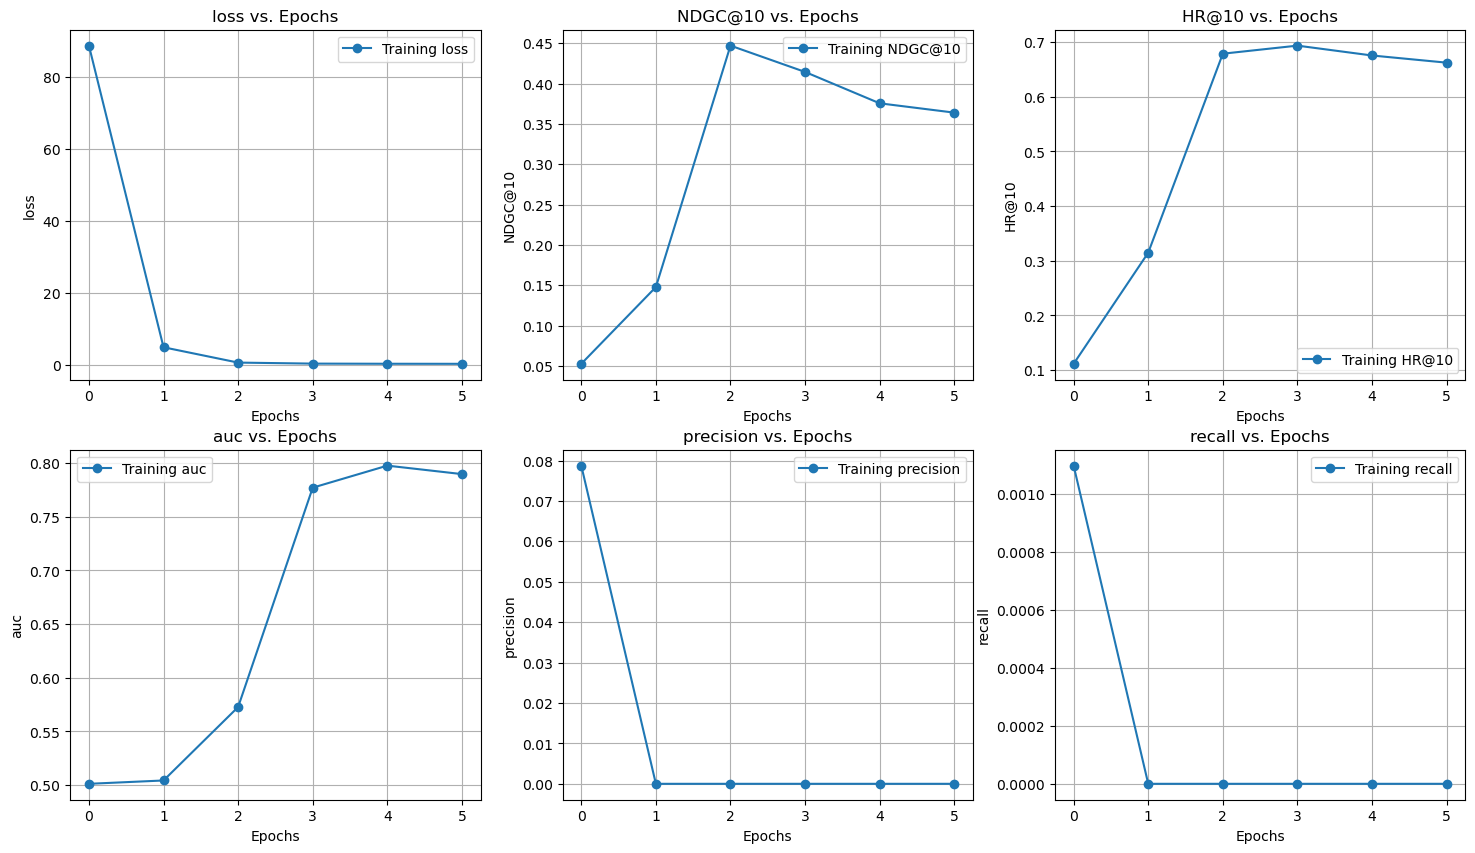

In [6]:
model.compile(
  optimizer="adam",
  loss="binary_crossentropy",
  metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
  ],
)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
earlyStoppingAtNDGC = EarlyStoppingAtNDGC(patience=3, test_data=test_data)

train_hist = model.fit(
  train_dataset,
  epochs=100,
  callbacks=[tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1), earlyStoppingAtNDGC],
  verbose=1
) 

make_metrics_vs_epochs_graphs(train_hist, earlyStoppingAtNDGC)

In [7]:
model.save("./models/NeuMF-ml-small.keras")